# Identifying suitable data

Identify suitable waveform data to be included in a study

---
## Specify an ICU stay

<div class="alert alert-block alert-warning"> <b>Resource:</b> These steps are taken from the <a href="https://wfdb.io/mimic_wfdb_tutorials/tutorial/notebooks/data-extraction.html">Data Extraction</a> tutorial. </div>

- Specify the required Python packages

In [22]:
import sys
import wfdb

- Get a list of ICU stays in the database

In [23]:
database_name = 'mimic3wdb/1.0' # The name of the MIMIC III Waveform Database on Physionet (see URL: https://physionet.org/content/mimic3wdb/1.0/)
icustay_records = wfdb.get_record_list(database_name)
print("There are {} ICU stays in the database".format(len(icustay_records)))

There are 67830 ICU stays in the database


- Specify an ICU stay

In [24]:
icustay_no = 10 # specify the first record (noting that in Python the first index is 0)
icustay_record = icustay_records[icustay_no]
icustay_record_dir = database_name + '/' + icustay_record
icustay_record_name = icustay_record.split("/")[1]
print("Specified ICU stay: {}".format(icustay_record_name))

Specified ICU stay: 3000125


---
## Check whether each segment of this ICU stay meets the requirements

- Identify the segments of this ICU stay

In [25]:
icustay_files = wfdb.get_record_list(icustay_record_dir)
icustay_segments = [s for s in icustay_files if "_" in s]
print("Identified {} segments in ICU stay: {}".format(len(icustay_segments), icustay_record_name))

Identified 36 segments in ICU stay: 3000125


- Specify the requirements

In [26]:
required_duration = 10*60 # in secs
required_signals = ["II", "PLETH"]

- Cycle through each segment in turn, finding out whether it contains the required signals and required duration of signals

In [27]:
icu_stays_and_segments_meeting_requirements = []
do_verbose = True
print(" ~~~ Cycling through {} segments ~~~".format(len(icustay_segments)))
for seg_no in range(0, len(icustay_segments)):
    # - extract the metadata for this segment
    icustay_segment_name = icustay_segments[seg_no]
    segment_metadata = wfdb.rdheader(record_name=icustay_segment_name, pn_dir=icustay_record_dir)
    # - find out whether this segment contains the required signals
    segment_contains_signals_log = True
    for sig_no in range(0, len(required_signals)):
        segment_contains_signals_log = segment_contains_signals_log and (required_signals[sig_no] in segment_metadata.sig_name)
    # - find out whether this segment lasts long enough
    segment_duration = segment_metadata.sig_len/segment_metadata.fs # in secs
    segment_signals_long_enough_log = segment_duration>=required_duration
    # - if this meets the requirements, then add this icu stay and segment to the list of ones meeting the requirements
    if segment_contains_signals_log and segment_signals_long_enough_log:
        # - add this icu stay and segment to the list of ones meeting the requirements
        icu_stays_and_segments_meeting_requirements.append([icustay_record,icustay_segment_name])
    if do_verbose:
        print("\n - Segment {} contains {} for {:.1f} seconds.".format(icustay_segments[seg_no], segment_metadata.sig_name, segment_duration), end="", flush=True)
        if segment_contains_signals_log and segment_signals_long_enough_log:
            print(' Therefore, it contains the required signals for the required duration', end="", flush=True)
        else:
            print(' Therefore, it doesn\'t contain the required signals for the required duration', end="", flush=True)
    else:
        print(".", end="", flush=True)
print("\n ~~~ Finished cycling through segments ~~~")
print("\n - Found {} segments containing required signals:".format(len(icu_stays_and_segments_meeting_requirements)))
print(icu_stays_and_segments_meeting_requirements)

 ~~~ Cycling through 36 segments ~~~

 - Segment 3000125_0001 contains ['II', 'III'] for 1.0 seconds. Therefore, it doesn't contain the required signals for the required duration
 - Segment 3000125_0002 contains ['PLETH'] for 3.0 seconds. Therefore, it doesn't contain the required signals for the required duration
 - Segment 3000125_0003 contains ['II', 'III', 'PLETH'] for 13095.0 seconds. Therefore, it contains the required signals for the required duration
 - Segment 3000125_0004 contains ['III', 'PLETH'] for 1.0 seconds. Therefore, it doesn't contain the required signals for the required duration
 - Segment 3000125_0005 contains ['II', 'III', 'PLETH'] for 136666.0 seconds. Therefore, it contains the required signals for the required duration
 - Segment 3000125_0006 contains ['II', 'V'] for 1.0 seconds. Therefore, it doesn't contain the required signals for the required duration
 - Segment 3000125_0007 contains ['PLETH'] for 4.0 seconds. Therefore, it doesn't contain the required sig

- Look at the segments which met the requirements:

In [28]:
print("[ ICU stay    ,  segment      ]")
for seg_no in range(0, len(icu_stays_and_segments_meeting_requirements)):
    print(icu_stays_and_segments_meeting_requirements[seg_no])

[ ICU stay    ,  segment      ]
['30/3000125/', '3000125_0003']
['30/3000125/', '3000125_0005']
['30/3000125/', '3000125_0008']
['30/3000125/', '3000125_0010']
['30/3000125/', '3000125_0013']
['30/3000125/', '3000125_0016']
['30/3000125/', '3000125_0018']
['30/3000125/', '3000125_0020']
['30/3000125/', '3000125_0022']
['30/3000125/', '3000125_0024']
['30/3000125/', '3000125_0026']
['30/3000125/', '3000125_0028']
['30/3000125/', '3000125_0031']
['30/3000125/', '3000125_0032']
['30/3000125/', '3000125_0034']
['30/3000125/', '3000125_0036']


---
## Check entire ICU stays
The approach of cycling through segments shown above takes quite a long time. Here's a quicker approach to eliminate entire ICU stays which don't contain the required signals:

- Specify the requirements (this time, we'll insist on having the ABP and PPG signals)

In [29]:
required_duration = 10*60 # in secs
required_signals = ["ABP", "PLETH"]

- Check whether this stay contains the required signals:

In [30]:
# - load metadata for entire ICU stay
icustay_layout_filename = icustay_record_name + "_layout"
icustay_metadata = wfdb.rdheader(record_name=icustay_layout_filename, pn_dir=icustay_record_dir)
print("\n - ICU stay {} contains the following signals: {}".format(icustay_record_name, icustay_metadata.sig_name), end="", flush=True)
# - check whether the stay contains the required signals
icustay_contains_signals_log = True
for sig_no in range(0, len(required_signals)):
    icustay_contains_signals_log = icustay_contains_signals_log and (required_signals[sig_no] in icustay_metadata.sig_name)
if icustay_contains_signals_log:
    print("  Therefore, it contains the required signals, so it's worth checking whether any individual segments meet the requirements", end="", flush=True)
else:
    print("  Therefore, it doesn't contain the required signals", end="", flush=True)


 - ICU stay 3000125 contains the following signals: ['II', 'III', 'PLETH', 'V']  Therefore, it doesn't contain the required signals

- Try cycling through a few ICU stays:

In [74]:
do_verbose = True
no_icustays = 27
icustay_records_with_signals = []
print(" ~~~ Cycling through {} ICU stays ~~~".format(no_icustays))
for icustay_no in range(0,no_icustays):
    icustay_record = icustay_records[icustay_no]
    icustay_record_dir = database_name + '/' + icustay_record
    icustay_record_name = icustay_record.split("/")[1]
    # - load metadata for this ICU stay
    icustay_layout_filename = icustay_record_name + "_layout"
    try:
        icustay_metadata = wfdb.rdheader(record_name=icustay_layout_filename, pn_dir=icustay_record_dir)
        if do_verbose:
            print("\n - ICU stay {} contains the following signals: {}.".format(icustay_record_name, icustay_metadata.sig_name), end="", flush=True)
    except:
        if do_verbose:
            print("\n - ICU stay {} didn't appear to contain any waveform data".format(icustay_record_name), end="", flush=True) # If the file can't be downloaded then it doesn't exist, which indicates there were no waveform data
        continue
    # - check whether the stay contains the required signals
    icustay_contains_signals_log = True
    for sig_no in range(0, len(required_signals)):
        icustay_contains_signals_log = icustay_contains_signals_log and (required_signals[sig_no] in icustay_metadata.sig_name)
    if icustay_contains_signals_log:
        icustay_records_with_signals.append(icustay_record)
        if do_verbose:
            print(" Therefore, it contains the required signals, so it's worth checking whether any individual segments meet the requirements.", end="", flush=True)
    else:
        if do_verbose:
            print(" Therefore, it doesn't contain the required signals.", end="", flush=True)
print("\n ~~~ Finished cycling through ICU stays ~~~")
print("\n - Found {} ICU stays containing required signals:".format(len(icustay_records_with_signals)))
print(icustay_records_with_signals)

 ~~~ Cycling through 27 ICU stays ~~~

 - ICU stay 3000003 contains the following signals: ['I', 'II', 'V', 'ABP', 'V+']. Therefore, it doesn't contain the required signals.
 - ICU stay 3000031 didn't appear to contain any waveform data
 - ICU stay 3000051 contains the following signals: ['II', 'III', 'AVR', 'V', 'RESP', 'PLETH']. Therefore, it doesn't contain the required signals.
 - ICU stay 3000060 contains the following signals: ['II', 'PLETH']. Therefore, it doesn't contain the required signals.
 - ICU stay 3000063 contains the following signals: ['PLETH', 'III', 'II', 'ABP']. Therefore, it contains the required signals, so it's worth checking whether any individual segments meet the requirements.
 - ICU stay 3000065 contains the following signals: ['II', 'MCL1', 'ABP']. Therefore, it doesn't contain the required signals.
 - ICU stay 3000086 contains the following signals: ['II', 'III', 'AVR', 'V', 'RESP', 'PLETH']. Therefore, it doesn't contain the required signals.
 - ICU stay 3

---
## See whether any segments in this ICU stay meet the requirements

- Specify an ICU stay

In [75]:
icustay_no = 4
icustay_record = icustay_records_with_signals[icustay_no]
icustay_record_dir = database_name + '/' + icustay_record
icustay_record_name = icustay_record.split("/")[1]
print("Specified ICU stay: {}".format(icustay_record_name))

Specified ICU stay: 3000435


- Identify the segments of this ICU stay

In [76]:
icustay_files = wfdb.get_record_list(icustay_record_dir)
icustay_segments = [s for s in icustay_files if "_" in s]
print("Identified {} segments in ICU stay: {}".format(len(icustay_segments), icustay_record_name))

Identified 5 segments in ICU stay: 3000435


- Cycle through a maximum of 10 segments in turn, finding out whether it contains the required signals and required duration of signals

In [77]:
icu_stays_and_segments_meeting_requirements = []
do_verbose = True
no_segments = min(10, len(icustay_segments))
print(" ~~~ Cycling through {} segments ~~~".format(no_segments))
for seg_no in range(0, no_segments):
    # - extract the metadata for this segment
    icustay_segment_name = icustay_segments[seg_no]
    segment_metadata = wfdb.rdheader(record_name=icustay_segment_name, pn_dir=icustay_record_dir)
    # - find out whether this segment contains the required signals
    segment_contains_signals_log = True
    for sig_no in range(0, len(required_signals)):
        segment_contains_signals_log = segment_contains_signals_log and (required_signals[sig_no] in segment_metadata.sig_name)
    # - find out whether this segment lasts long enough
    segment_duration = segment_metadata.sig_len/segment_metadata.fs # in secs
    segment_signals_long_enough_log = segment_duration>=required_duration
    # - if this meets the requirements, then add this icu stay and segment to the list of ones meeting the requirements
    if segment_contains_signals_log and segment_signals_long_enough_log:
        # - add this icu stay and segment to the list of ones meeting the requirements
        icu_stays_and_segments_meeting_requirements.append([icustay_record,icustay_segment_name])
    if do_verbose:
        print("Segment {} contains {} for {:.1f} seconds".format(icustay_segments[seg_no], segment_metadata.sig_name, segment_duration))
        if segment_contains_signals_log and segment_signals_long_enough_log:
            print(' - i.e. It contains the required signals for the required duration')
        else:
            print(' - i.e. It doesn\'t contain the required signals for the required duration')
    else:
        print(".", end="", flush=True)
print("\n ~~~ Finished cycling through segments ~~~")
print("\n - Found {} segments containing required signals:".format(len(icu_stays_and_segments_meeting_requirements)))
print(icu_stays_and_segments_meeting_requirements)

 ~~~ Cycling through 5 segments ~~~
Segment 3000435_0001 contains ['II', 'PLETH'] for 1.0 seconds
 - i.e. It doesn't contain the required signals for the required duration
Segment 3000435_0002 contains ['II', 'ABP', 'PLETH'] for 65276.0 seconds
 - i.e. It contains the required signals for the required duration
Segment 3000435_0003 contains ['II', 'PLETH'] for 8108.0 seconds
 - i.e. It doesn't contain the required signals for the required duration
Segment 3000435_0004 contains ['II'] for 410.0 seconds
 - i.e. It doesn't contain the required signals for the required duration
Segment 3000435_0005 contains ['II', 'PLETH'] for 11236.0 seconds
 - i.e. It doesn't contain the required signals for the required duration

 ~~~ Finished cycling through segments ~~~

 - Found 1 segments containing required signals:
[['30/3000435/', '3000435_0002']]


---
## Extract data for a segment meeting the requirements

- Specify the segment

In [78]:
segment_no = 0
icustay_segment_name = icu_stays_and_segments_meeting_requirements[segment_no][1]
icustay_record = icu_stays_and_segments_meeting_requirements[segment_no][0]
icustay_record_dir = database_name + '/' + icustay_record
icustay_record_name = icustay_record.split("/")[1]
print("Specified segment {} in ICU stay {}".format(icustay_segment_name, icustay_record_name))

Specified segment 3000435_0002 in ICU stay 3000435


- Find out the sampling frequency of the waveform data

In [79]:
segment_metadata = wfdb.rdheader(record_name=icustay_segment_name, pn_dir=icustay_record_dir)
fs = segment_metadata.fs

- Extract the specified data

In [80]:
required_duration = 10*60 # duration in seconds
start_seconds = 0 # time since the start of the segment at which to begin extracting data
sampfrom = fs*start_seconds
sampto = fs*(start_seconds+required_duration)
segment_data = wfdb.rdrecord(record_name=icustay_segment_name, sampfrom=sampfrom, sampto=sampto, pn_dir=icustay_record_dir) 
print("{} seconds of data extracted from: {}".format(required_duration, icustay_segment_name))

600 seconds of data extracted from: 3000435_0002


---
## Plot signals in this segment
Plot the signals contained in this segment

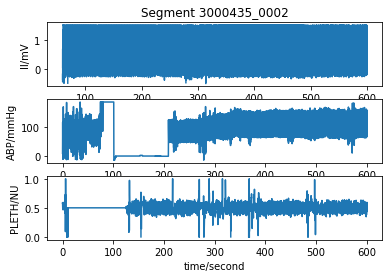

In [81]:
title_text = "Segment " + icustay_segment_name
wfdb.plot_wfdb(record=segment_data, title=title_text, time_units='seconds') 

- Let's have a closer look at 10 seconds of data

10 seconds of data extracted from: 3000435_0002


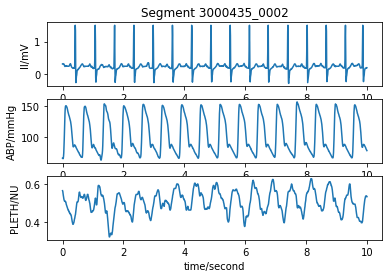

In [82]:
required_duration = 10 # duration in seconds
start_seconds = 400 # time since the start of the segment at which to begin extracting data
sampfrom = fs*start_seconds
sampto = fs*(start_seconds+required_duration)
segment_data = wfdb.rdrecord(record_name=icustay_segment_name, sampfrom=sampfrom, sampto=sampto, pn_dir=icustay_record_dir) 
print("{} seconds of data extracted from: {}".format(required_duration, icustay_segment_name))
wfdb.plot_wfdb(record=segment_data, title=title_text, time_units='seconds') 

<div class="alert alert-block alert-info"> <b>Q:</b> How suitable were the signals for the other four ICU stays identified which met these requirements? Could we use all of these ICU stays in a study? <br> <b>Hint:</b> Above, try changing 'icustay_no' from '4' to a value between '0' and '3'. </div>